## Lab 01. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [48]:
import string
import os
import torch, torch.nn as nn
import torch.nn.functional as F
from random import sample
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [6]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [7]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = "".join(word.lower() for word in text)

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


### Data loading: "Евгений Онегин"


In [5]:
!wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
    
with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

--2021-04-28 10:48:43--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256,37K  1,44MB/s    in 0,2s    

2021-04-28 10:48:44 (1,44 MB/s) - ‘onegin.txt’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here


Put all the characters, that you've seen in the text, into variable `tokens`.

In [9]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [14]:
# dict <index>:<char>
token_to_idx = {char: index for index, char in enumerate(tokens)}

# dict <char>:<index>
idx_to_token = {index: char for char, index in token_to_idx.items()}

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [19]:
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.
        
        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        x_emb = self.embedding(x)

        x_and_h = torch.cat([x_emb, h_prev], dim=1)
        h_next = self.rnn_update(x_and_h)   
        h_next = torch.tanh(h_next) 
              
        assert h_next.size() == h_prev.size()
        
        logits = self.rnn_to_logits(h_next)             
        return h_next, F.log_softmax(logits, -1)
    
    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)

In [37]:
def to_matrix(text, max_len=None, pad=token_to_idx[' '], dtype='int32', batch_first = True):
    """Casts a list of words into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, text))
    text_ix = np.zeros([len(text), max_len], dtype) + pad

    for i in range(len(text)):
        line_ix = [token_to_idx[c] for c in text[i]]
        text_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first:
        text_ix = np.transpose(text_ix)

    return text_ix

def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        hid_state, logp_next = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [83]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()
opt = torch.optim.Adam(char_rnn.parameters())
history = []

In [84]:
text_splitted = [' ' + word.strip()  for word in text.split('\n')]
MAX_LENGTH = max(map(len,text_splitted))

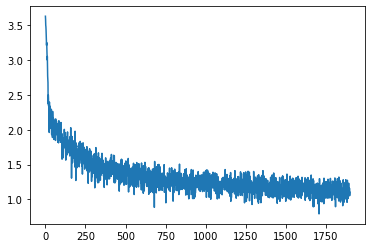

In [85]:
NUM_STEPS = 2000

loss_history = np.zeros(NUM_STEPS)

for i in range(NUM_STEPS):
    batch_ix = to_matrix(sample(text_splitted, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
    
    logp_seq = rnn_loop(char_rnn, batch_ix)
    
    # compute loss
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = criterion(
        predictions_logp.contiguous().view(-1, len(tokens)),
        actual_next_tokens.contiguous().view(-1)
    ) 
    
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    loss_history[i] = loss.data.numpy().tolist()
    if i % 100 == 0:
        print(f'Current iteration: {i}, actual loss: {loss.data.numpy()}')
        clear_output(True)
        plt.plot(loss_history[:i+1])
        plt.show()

In [93]:
def generate_sample(char_rnn, max_length=MAX_LENGTH, seed_phrase=' Hello', temperature=1):
    char_rnn.eval()
    phrase = seed_phrase
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).transpose(1, 0)
    hidden_state = char_rnn.initial_state(1)
    
    with torch.no_grad():
        for char in x_sequence:
            hidden_state, logits = char_rnn(char, hidden_state)
        
        for _ in range(max_length - len(seed_phrase)):
            probs = nn.Softmax(dim=1)(logits / temperature).numpy().flatten()
            next_token_idx = np.random.choice(np.arange(len(tokens)), p=probs)
            phrase += idx_to_token[next_token_idx]
            token_tensor = torch.tensor([next_token_idx], dtype=torch.int64)
            hidden_state, logits = char_rnn(token_tensor, hidden_state)
    
    return phrase

In [95]:
for i in range(5):
    print(generate_sample(char_rnn, temperature=0.5, seed_phrase=" "))

 the hath thou the should the barse all where pided breing,  
 the hat the forth that so indan the stay,                   
 sompore the make the feat i as in thou the at fall the hith 
 the praind dight then the the stear heart of the my for the 
                                                             


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [119]:
class LSTM(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units
        
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.LSTM(embedding_size, rnn_num_units, batch_first=True)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, hidden_state=None):
        out_hidden, state = self.rnn_update(self.embedding(x), hidden_state)
        logits = self.rnn_to_logits(out_hidden)
        return state, logits

In [120]:
BATCH_SIZE = 128
model = LSTM()
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [47]:
# Text generation with different temperature values here

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [4]:
# Saving and loading code here

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)